# EDA and Pre Processing

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("fashion-dataset/styles.csv", nrows=5000, on_bad_lines='skip')

# Addig new column for 'image' based on the 'id' column
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

df = df.reset_index(drop=True)

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [2]:
train_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
4227,55868,Women,Personal Care,Nails,Nail Polish,Pink,Spring,2017,Casual,Colorbar Fushia Fix 2 Nail Lacquer 84,55868.jpg
4676,34400,Men,Apparel,Topwear,Tshirts,Black,Summer,2012,Casual,Myntra Men Planet Earth Black T-shirt,34400.jpg
800,4972,Men,Apparel,Topwear,Shirts,Green,Summer,2011,Casual,Gini and Jony Boy's Kangaroo Green White Kidswear,4972.jpg
3671,3363,Women,Apparel,Topwear,Tshirts,Black,Summer,2011,Casual,Myntra Women Creative designs Black T-shirt,3363.jpg
4193,24695,Men,Footwear,Sandal,Sandals,Black,Summer,2011,Casual,Lotto Men Hermes Black Sandals,24695.jpg
...,...,...,...,...,...,...,...,...,...,...,...
4426,58310,Men,Accessories,Socks,Socks,Black,Summer,2016,Sports,Jockey LCESCBRA Men Pack of 3 Socks 2004,58310.jpg
466,30802,Men,Apparel,Topwear,Shirts,Blue,Summer,2012,Ethnic,Fabindia Men Blue Shirt,30802.jpg
3092,11180,Men,Accessories,Watches,Watches,Brown,Winter,2016,Casual,Carrera Men White Dial Watch,11180.jpg
3772,20054,Women,Accessories,Mufflers,Mufflers,Black,Fall,2011,Casual,United Colors Of Benetton Women Black Muffler,20054.jpg


In [3]:
# displaying all categories in the dataset

def print_all_categories(df, category_name):
    categories = df[category_name].unique()
    print("All Categories:")
    for category in categories:
        print(category)

print_all_categories(train_df, 'masterCategory')

All Categories:
Personal Care
Apparel
Footwear
Accessories
Free Items


Image path: fashion-dataset/images\55868.jpg
Image path: fashion-dataset/images\34400.jpg
Image path: fashion-dataset/images\24695.jpg
Image path: fashion-dataset/images\40519.jpg
Image path: fashion-dataset/images\29981.jpg


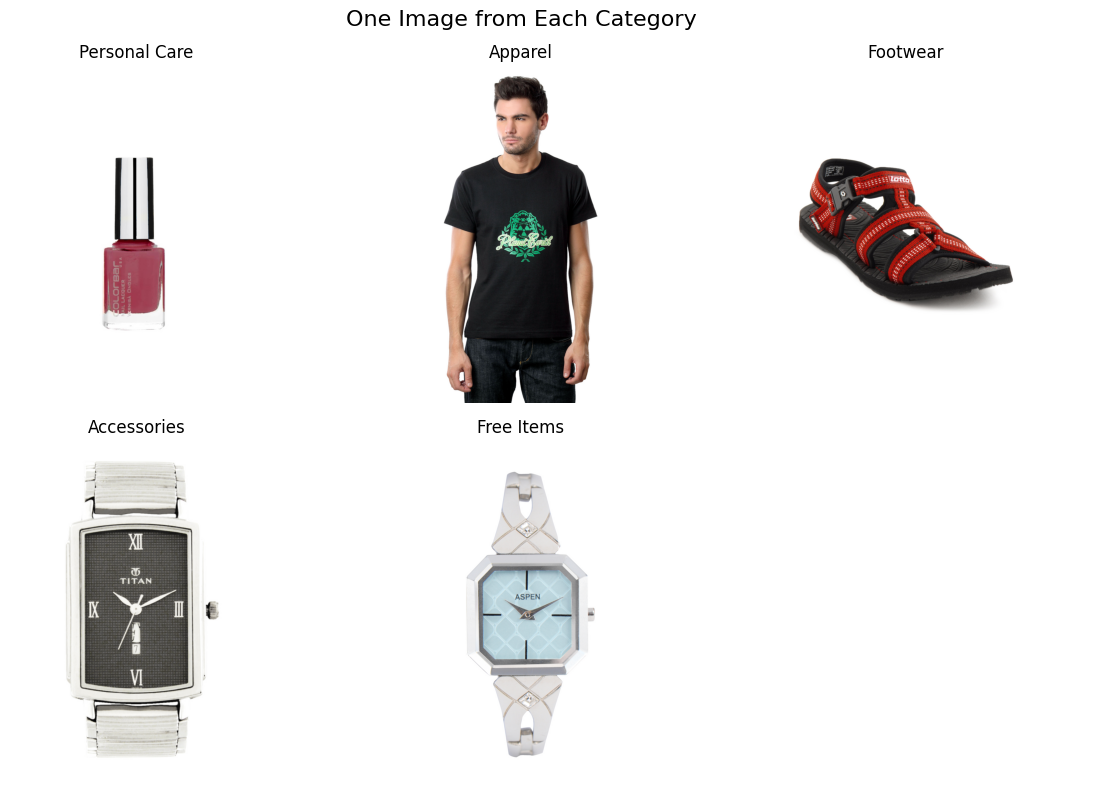

In [4]:
import matplotlib.pyplot as plt
import cv2

def display_one_image_per_category(df, category_name):
    categories = df[category_name].unique()
    nrows = len(categories) // 3 + (len(categories) % 3 > 0) 
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        filtered_df = df[df[category_name] == category]
        if len(filtered_df) > 0:
            image_path = os.path.join("fashion-dataset/images", filtered_df.iloc[0]['image'])
            print("Image path:", image_path)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[i].imshow(image_rgb)
                    axes[i].set_title(category)
                    axes[i].axis('off')
                else:
                    print("Error: Unable to read image at path:", image_path)
                    axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                    axes[i].axis('off')
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")
                axes[i].text(0.5, 0.5, 'Error loading image', ha='center', va='center')
                axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"One Image from Each Category", fontsize=16)
    plt.tight_layout()
    plt.show()

display_one_image_per_category(train_df, 'masterCategory')

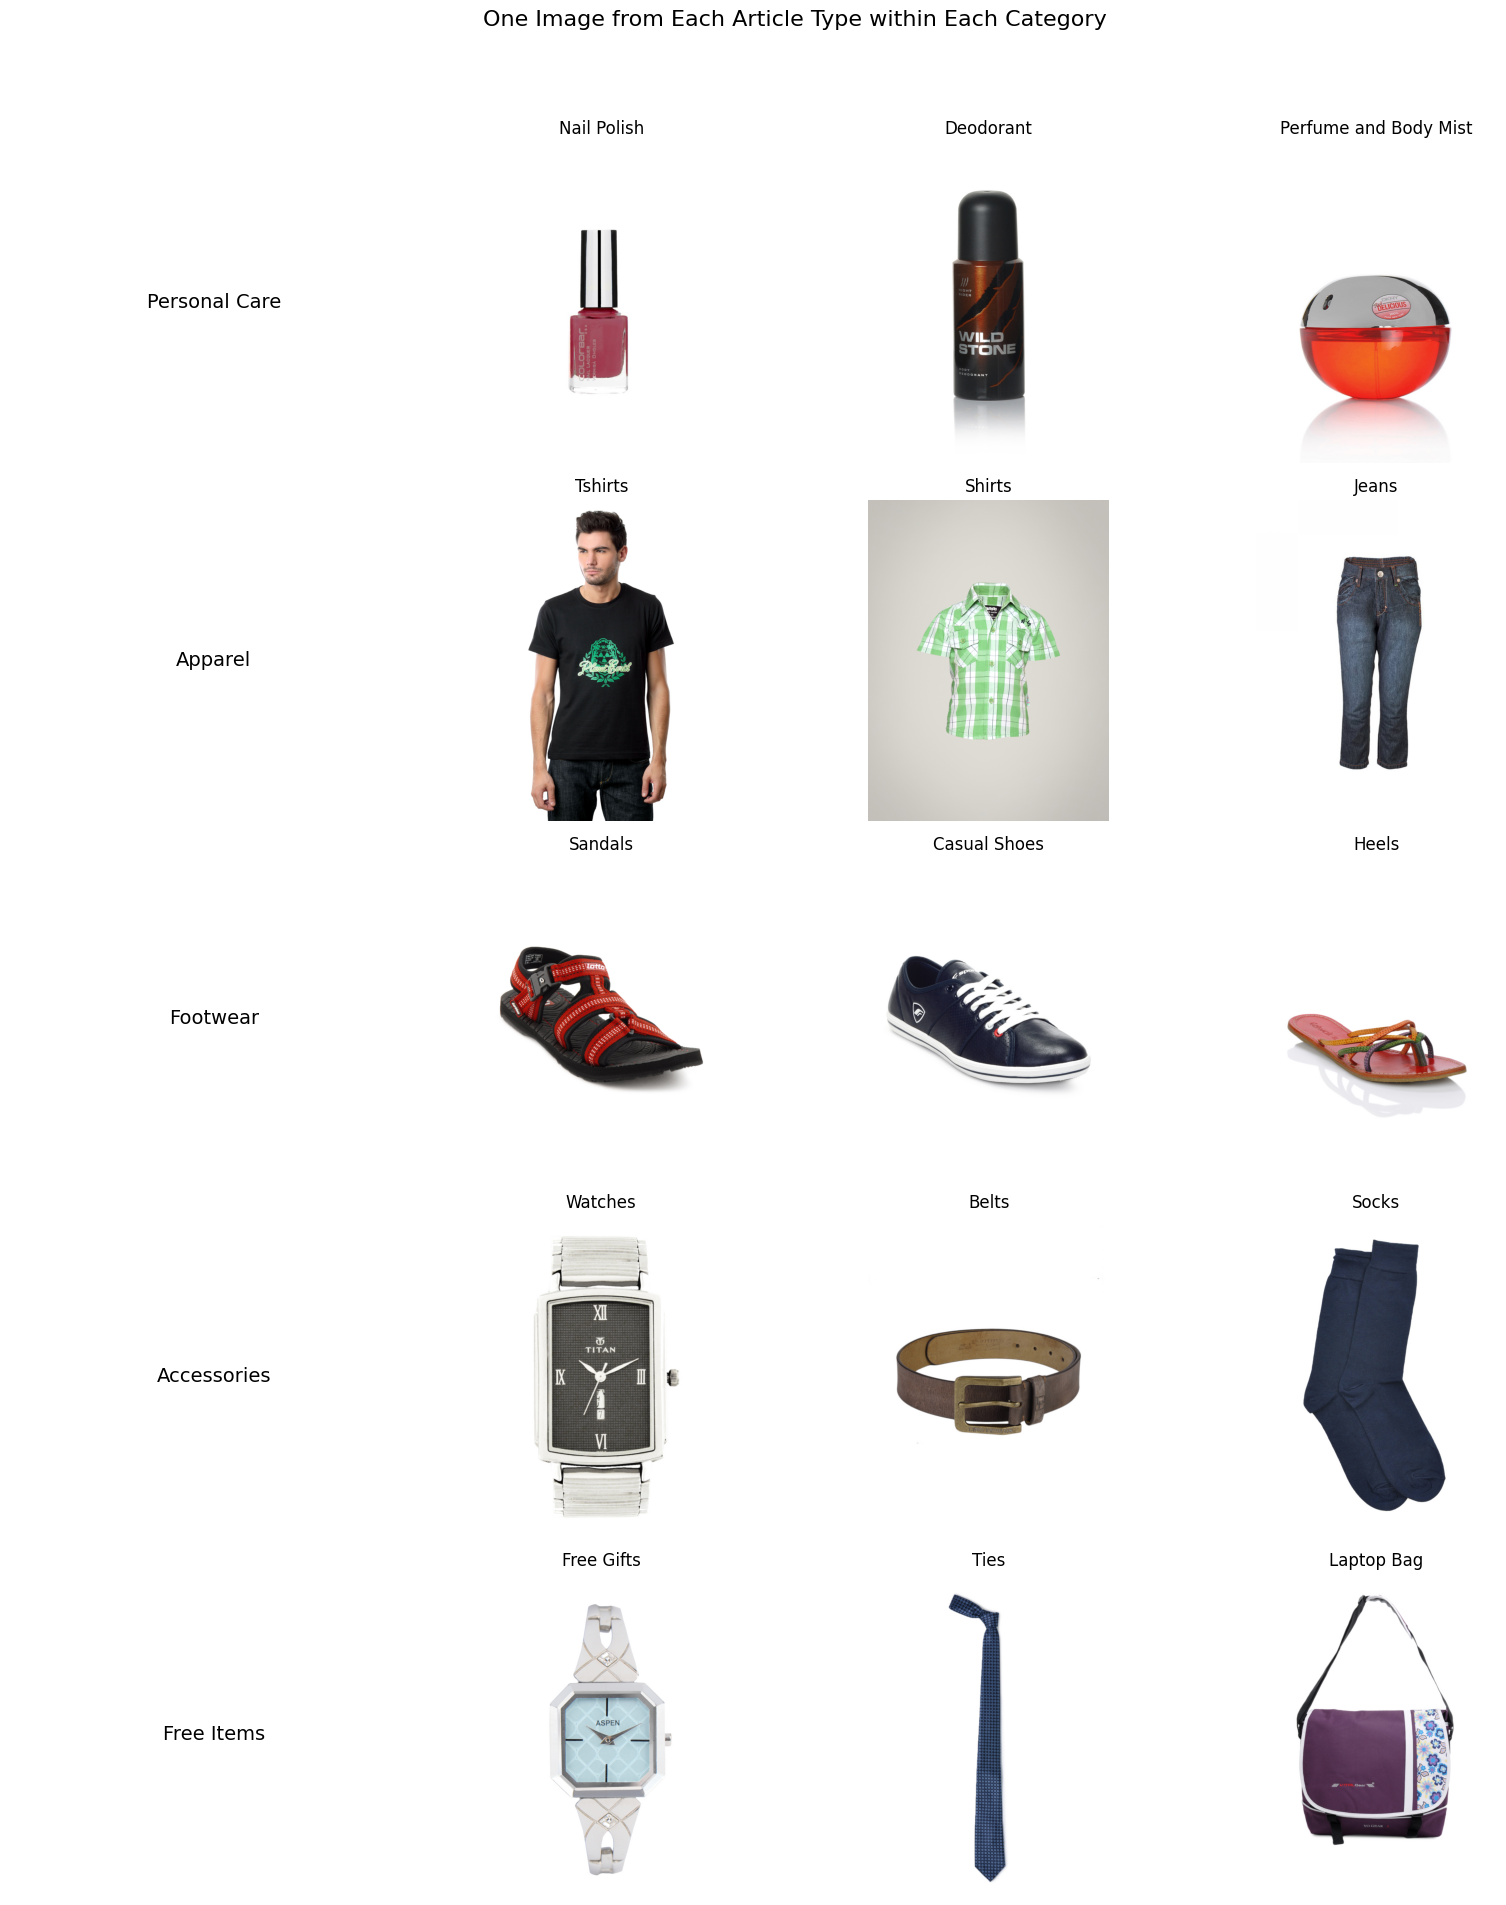

In [5]:
import matplotlib.pyplot as plt
import cv2

def display_one_image_per_article_per_category(df, category_name, article_type_name):
    categories = df[category_name].unique()
    nrows = len(categories)
    
    # Calculate max number of article types across all categories
    max_articles = max(len(df[df[category_name] == cat][article_type_name].unique()) for cat in categories)
    ncols = min(max_articles + 1, 4)  # Add 1 for category name column, cap at 4
    
    # Adjust figure size based on number of rows and columns
    fig_width = ncols * 4  # 4 inches per column
    fig_height = nrows * 4  # 4 inches per row
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))

    for i, category in enumerate(categories):
        axes[i, 0].text(0.5, 0.5, category, fontsize=14, ha='center', va='center')
        axes[i, 0].axis('off')

        filtered_df = df[df[category_name] == category]
        article_types = filtered_df[article_type_name].unique()
        for j, article_type in enumerate(article_types[:ncols-1]):  # Display images up to ncols-1
            filtered_by_type_df = filtered_df[filtered_df[article_type_name] == article_type]
            if len(filtered_by_type_df) > 0:
                image_path = os.path.join("fashion-dataset/images", filtered_by_type_df.iloc[0]['image'])
                image = cv2.imread(image_path)
                if image is not None:
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    axes[i, j + 1].imshow(image_rgb)
                    axes[i, j + 1].set_title(article_type)
                    axes[i, j + 1].axis('off')
                else:
                    print("Error: Unable to read image at path:", image_path)
                    
        # Hide unused subplot axes
        for j in range(len(article_types[:ncols-1]) + 1, ncols):
            axes[i, j].axis('off')

    plt.suptitle("One Image from Each Article Type within Each Category", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_one_image_per_article_per_category(train_df, 'masterCategory', 'articleType')


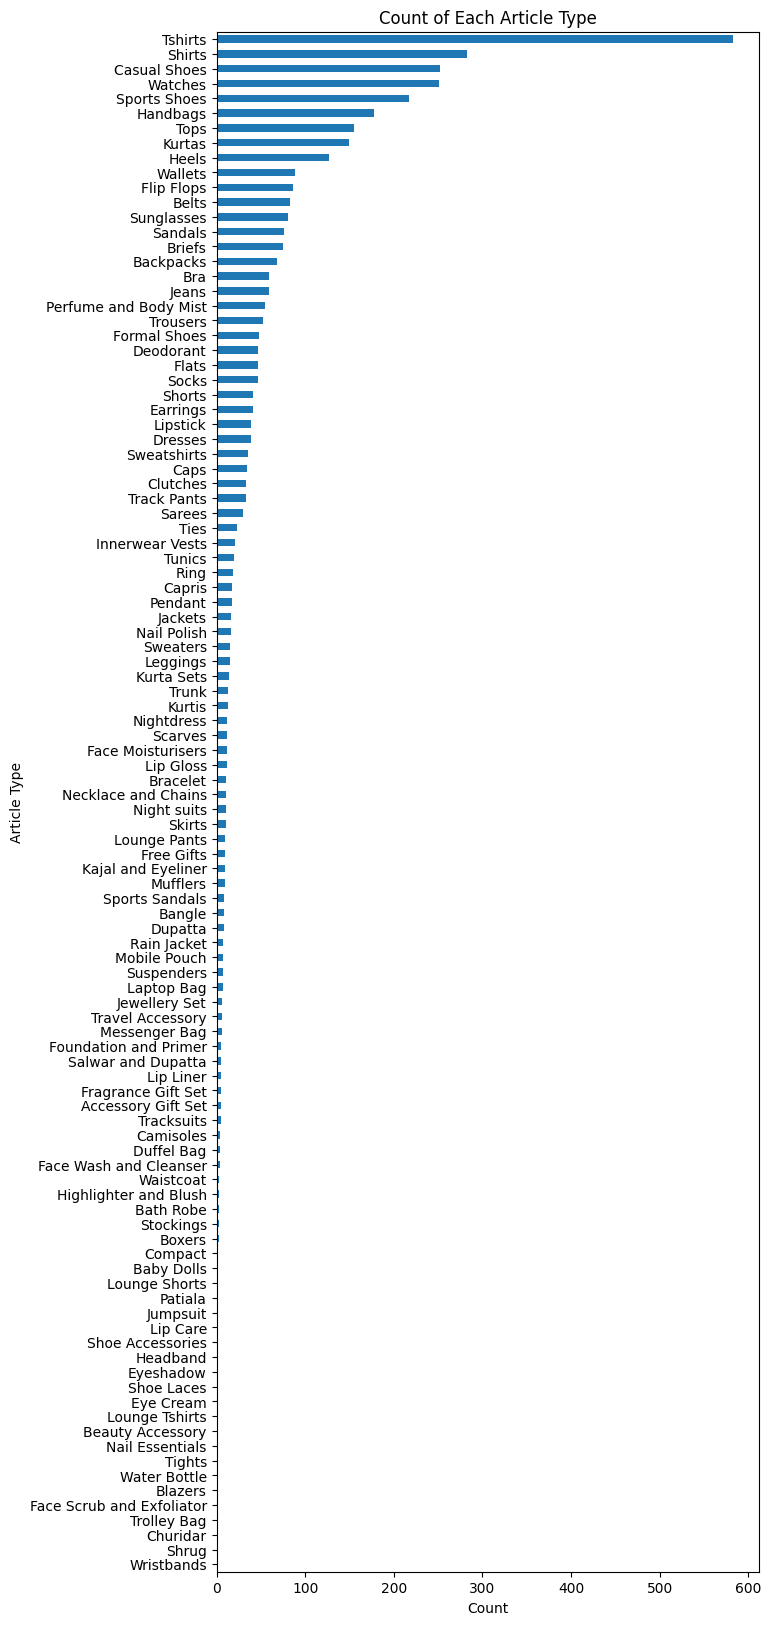

In [6]:
plt.figure(figsize=(7, 20))
train_df['articleType'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Article Type')
plt.title('Count of Each Article Type')
plt.show()


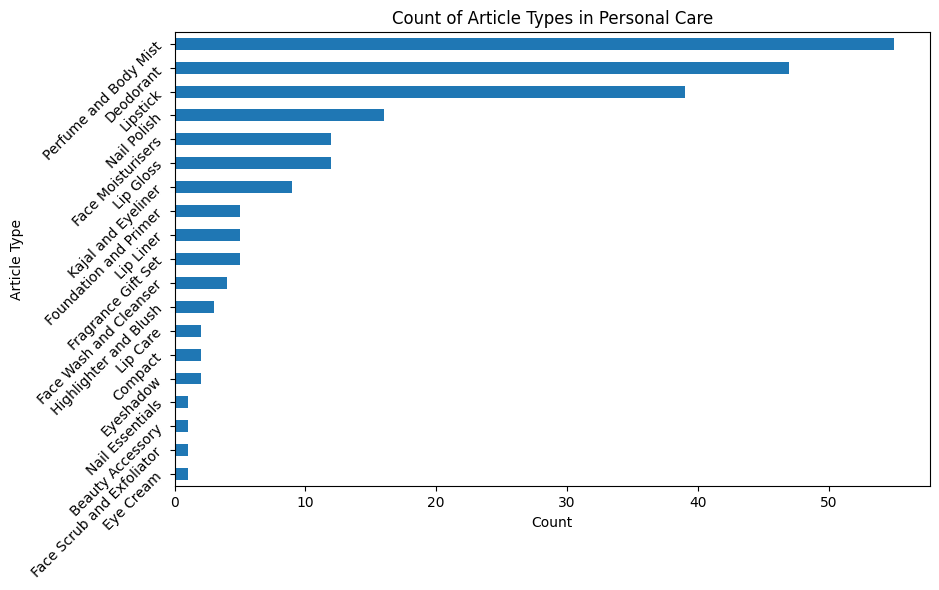

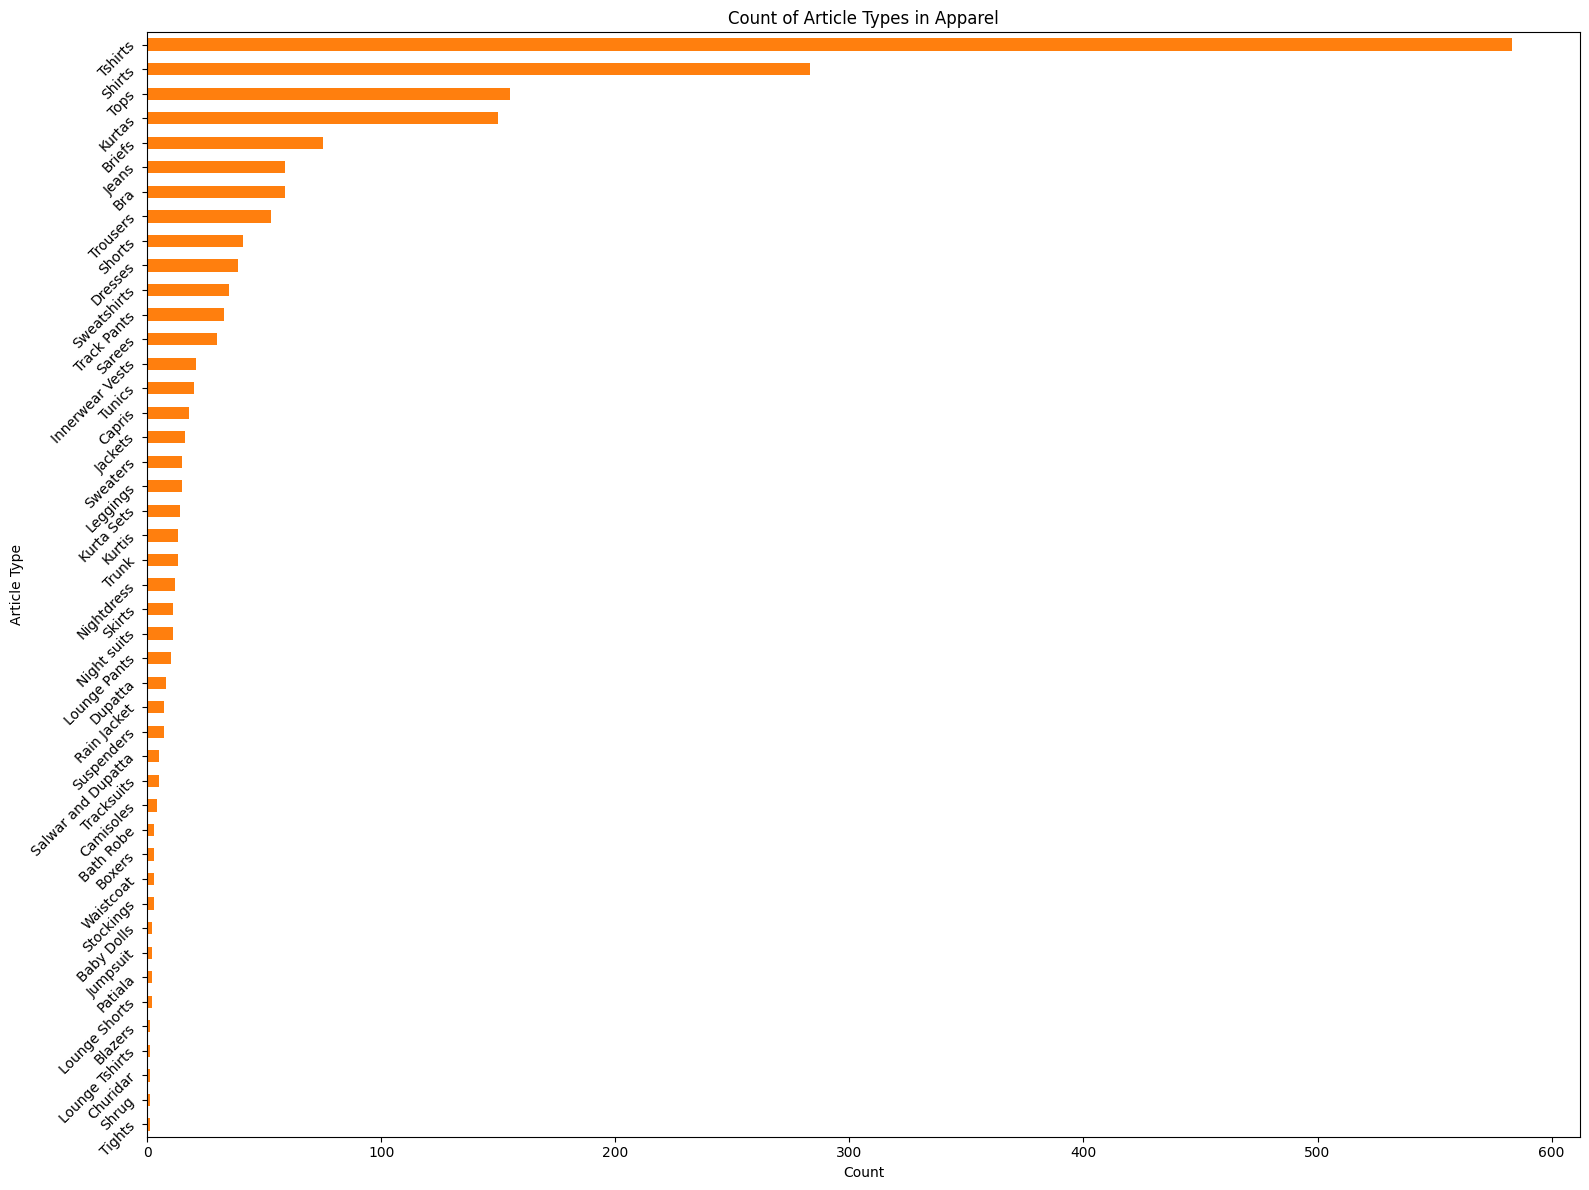

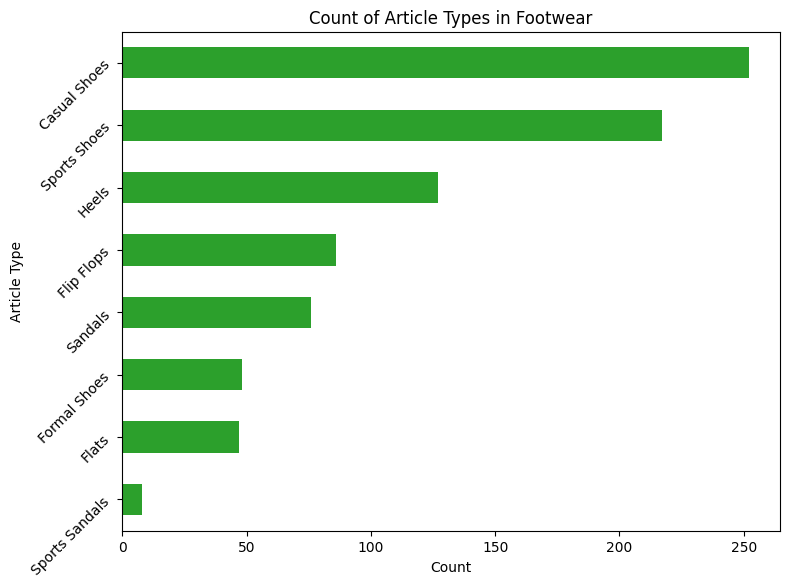

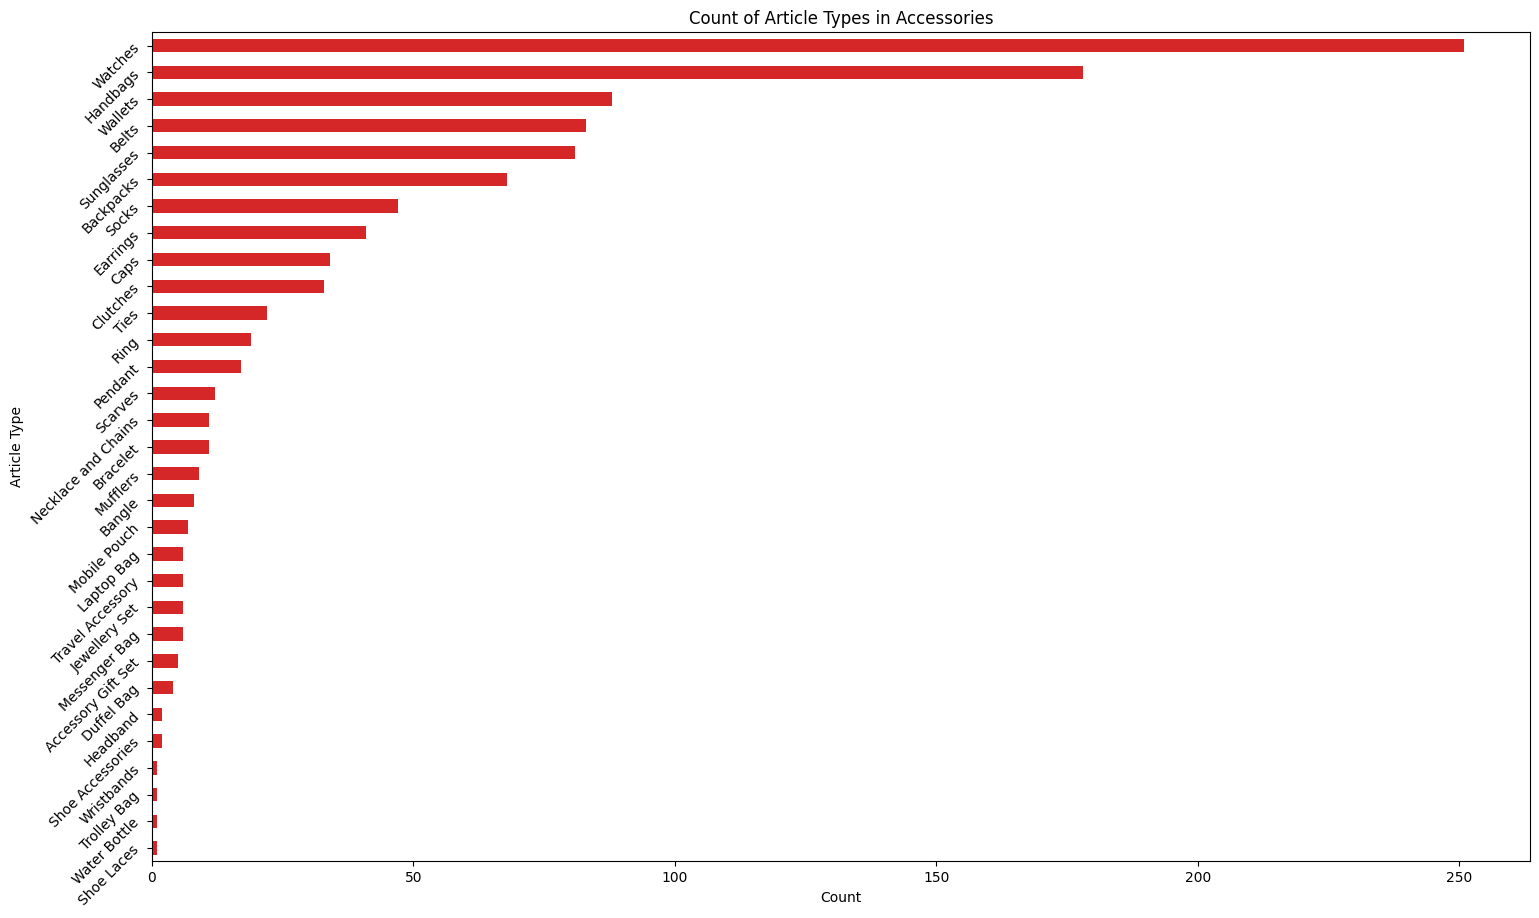

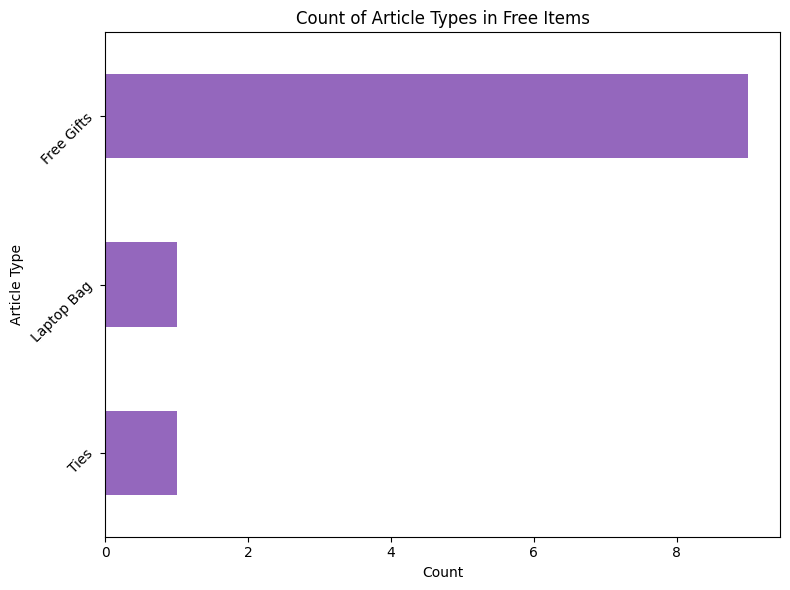

In [7]:
import matplotlib.pyplot as plt

def plot_article_type_count(df, category_name, article_type_name):
    categories = df[category_name].unique()

    for i, category in enumerate(categories):
        # Filter DataFrame for the current category
        filtered_df = df[df[category_name] == category]
        article_type_counts = filtered_df[article_type_name].value_counts().sort_values()

        # Determine the figure size based on the number of article types
        num_article_types = len(article_type_counts)
        fig_width = min(max(num_article_types * 0.5, 8), 16)
        fig_height = min(max(num_article_types * 0.3, 6), 12)

        plt.figure(figsize=(fig_width, fig_height))
        ax = plt.subplot(1, 1, 1)
        article_type_counts.plot(kind='barh', ax=ax, color=f'C{i}')
        ax.set_xlabel('Count')
        ax.set_ylabel('Article Type')
        ax.set_title(f'Count of Article Types in {category}')
        ax.tick_params(axis='y', labelrotation=45)  # Rotate article names
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()


plot_article_type_count(train_df, 'masterCategory', 'articleType')


In [8]:
# Function to preprocess images
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Using CNN for Feature Extraction

In [9]:
# Loading pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
# Function to extract features
def extract_features(model, img_path):
    img = preprocess_image(img_path)
    features = model.predict(img)
    return features.flatten()

In [11]:
# Function to save data
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Function to load data
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data


In [13]:
# Check if the data is already computed and saved
train_features_file = 'train_features.pkl'
test_features_file = 'test_features.pkl'

if os.path.exists(train_features_file) and os.path.exists(test_features_file):
    # Load the precomputed features
    train_features = load_data(train_features_file)
    test_features = load_data(test_features_file)
else:
    # Compute and save features for training images
    train_features = {}
    for _, row in train_df.iterrows():
        img_path = os.path.join("fashion-dataset/images", row['image'])
        train_features[row['id']] = extract_features(model, img_path)
    save_data(train_features, train_features_file)

    # Compute and save features for testing images
    test_features = {}
    for _, row in test_df.iterrows():
        img_path = os.path.join("fashion-dataset/images", row['image'])
        test_features[row['id']] = extract_features(model, img_path)
    save_data(test_features, test_features_file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━

# Computing Similarity between Items

In [14]:
# Check if recommendations are already computed and saved
recommendations_file = 'recommendations.pkl'

if os.path.exists(recommendations_file):
    # Load precomputed recommendations
    recommendations = load_data(recommendations_file)
else:
    # Generate and save recommendations for testing images
    recommendations = {}
    for query_image_id in test_features.keys():
        query_feature = test_features[query_image_id].reshape(1, -1)
        similarities = {}
        for train_image_id, train_feature in train_features.items():
            similarity = cosine_similarity(query_feature, train_feature.reshape(1, -1))[0][0]
            similarities[train_image_id] = similarity
        top_similar_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:6]
        recommendations[query_image_id] = top_similar_images
    save_data(recommendations, recommendations_file)


# Visualizing Recommendations

Query Image ID: 6413
Recommended Images:


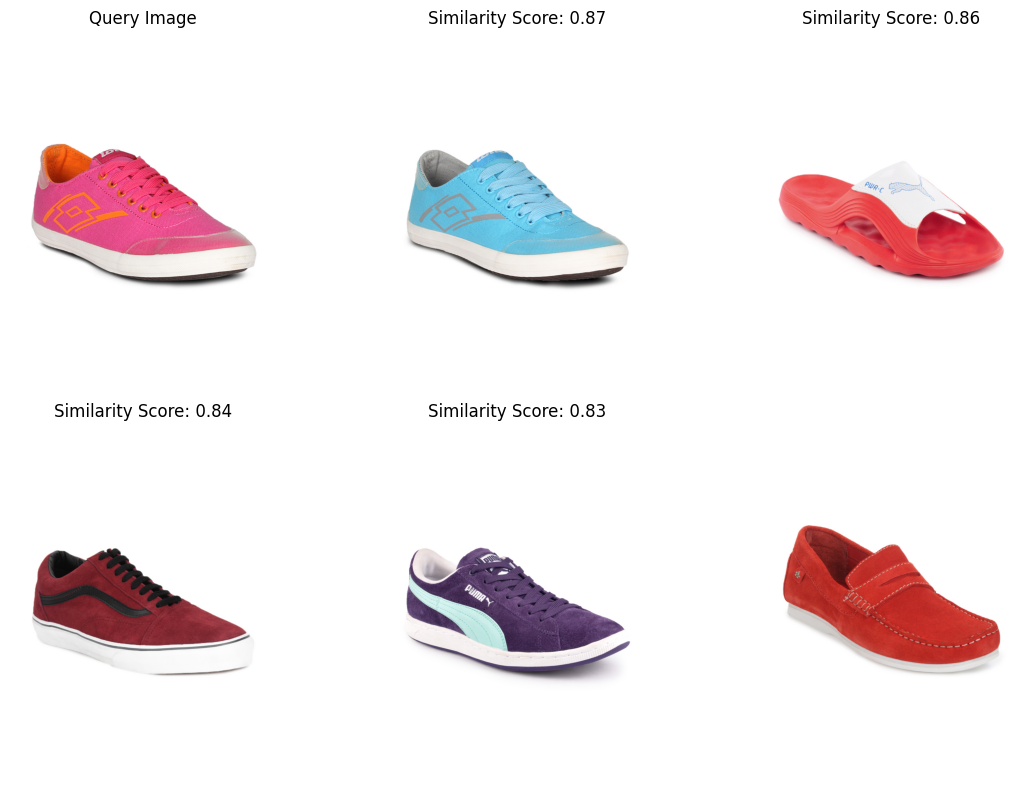

Query Image ID: 15785
Recommended Images:


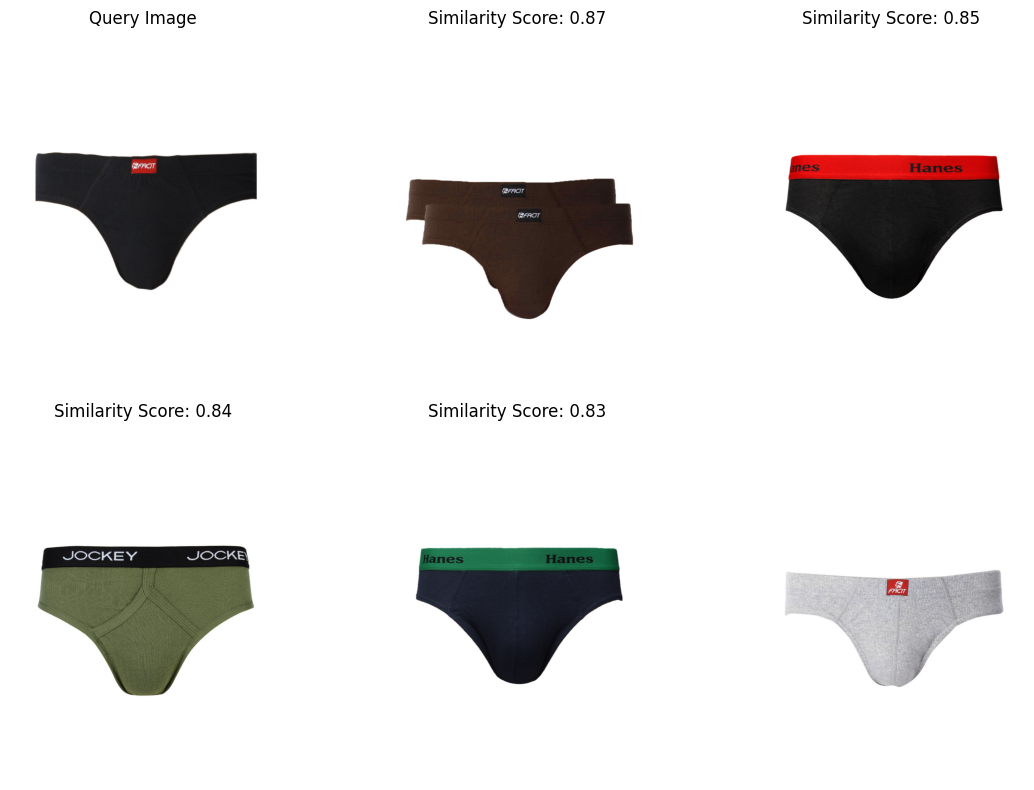

Query Image ID: 13284
Recommended Images:


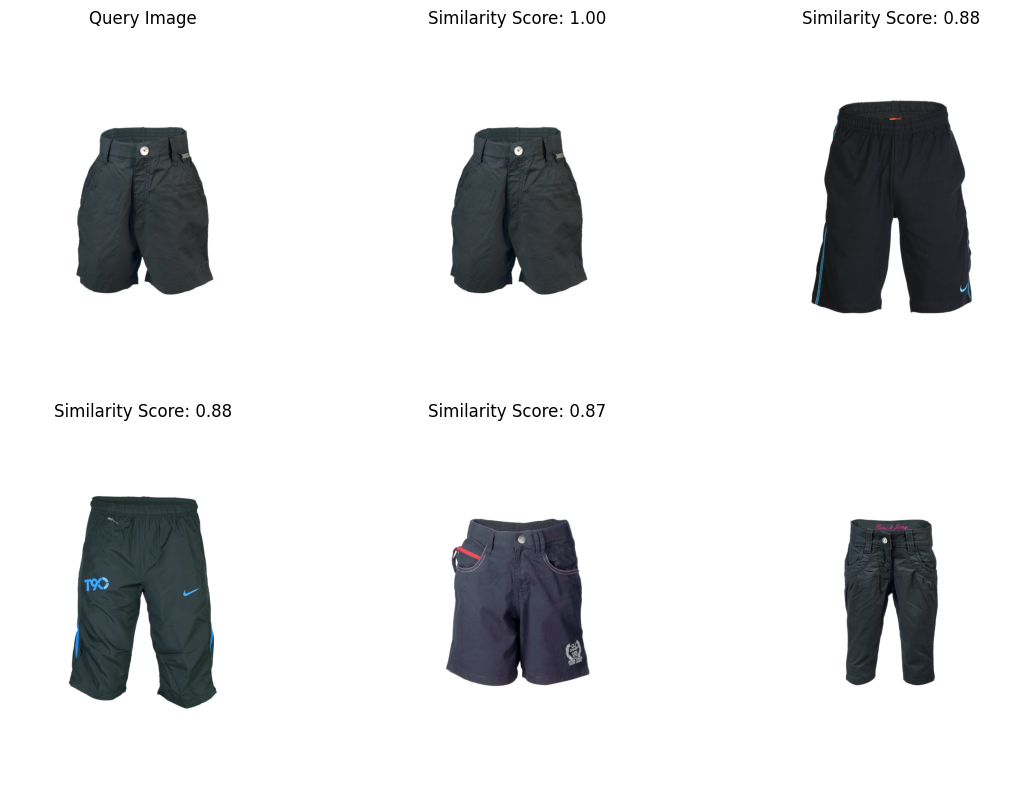

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import random

# Randomly select a few query images
query_image_ids = random.sample(list(recommendations.keys()), 3)

# Display recommendations for each query image
for query_image_id in query_image_ids:
    print("Query Image ID:", query_image_id)
    print("Recommended Images:")
    
    # Load and display the query image
    query_image_path = os.path.join("fashion-dataset/images", f"{query_image_id}.jpg")
    query_image = Image.open(query_image_path)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    
    # Display top 6 recommended images
    for i, (recommended_image_id, similarity_score) in enumerate(recommendations[query_image_id][:6], start=2):
        if i <= 6:  # Limit to 6 images
            recommended_image_path = os.path.join("fashion-dataset/images", f"{recommended_image_id}.jpg")
            recommended_image = Image.open(recommended_image_path)
            plt.subplot(2, 3, i)
            plt.imshow(recommended_image)
            plt.title(f"Similarity Score: {similarity_score:.2f}")
            plt.axis('off')
    
    ax = plt.gca()
    ax.set_title('')
    
    plt.tight_layout()
    plt.show()


# Evaluating the System (HR AND NDCG)

In [16]:
# Creating a dictionary of relevant images for each query image in the testing set
test_data = {}
for _, row in test_df.iterrows():
    query_image_id = row['id']
    relevant_images = train_df[train_df['masterCategory'] == row['masterCategory']]['id'].tolist()
    test_data[query_image_id] = relevant_images

# Function to compute hit ratio
def compute_hit_ratio(recommendations, test_data):
    hit_count = 0
    for query_image_id, recommended_images in recommendations.items():
        relevant_images = test_data[query_image_id]
        for img_id, _ in recommended_images:
            if img_id in relevant_images:
                hit_count += 1
                break
    hit_ratio = hit_count / len(recommendations)
    return hit_ratio

# Function to compute nDCG
def compute_nDCG(recommendations, test_data):
    nDCG_sum = 0
    for query_image_id, recommended_images in recommendations.items():
        relevant_images = test_data[query_image_id]
        DCG = 0
        IDCG = 0
        for i, (img_id, _) in enumerate(recommended_images):
            if img_id in relevant_images:
                relevance = 1
            else:
                relevance = 0
            DCG += relevance / np.log2(i + 2)
            IDCG += 1 / np.log2(i + 2)
        nDCG_sum += DCG / IDCG
    nDCG = nDCG_sum / len(recommendations)
    return nDCG

# Evaluate the recommendation system
hit_ratio = compute_hit_ratio(recommendations, test_data)
nDCG = compute_nDCG(recommendations, test_data)

print("Hit Ratio:", hit_ratio)
print("nDCG:", nDCG)


Hit Ratio: 0.992
nDCG: 0.9796716764764357


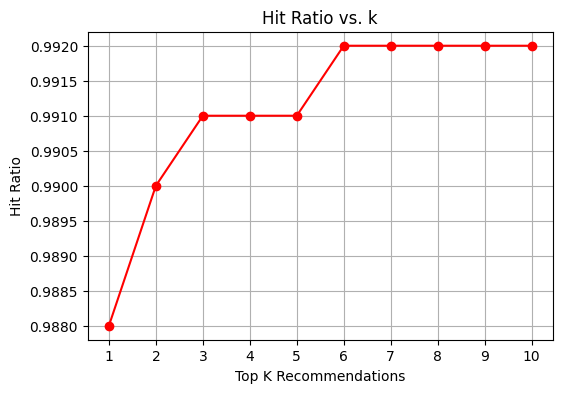

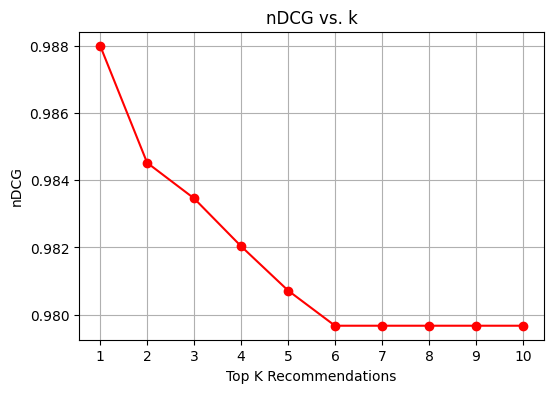

In [17]:
import matplotlib.pyplot as plt

k_values = range(1, 11)

# Initialize lists to store hit ratio and nDCG values
hit_ratio_values = []
nDCG_values = []

# Compute hit ratio and nDCG for each k
for k in k_values:
    # Get recommendations for the current k
    recommendations_k = {query_image_id: recommendations[query_image_id][:k] for query_image_id in recommendations}
    
    # Compute hit ratio for the current k
    hit_ratio_k = compute_hit_ratio(recommendations_k, test_data)
    hit_ratio_values.append(hit_ratio_k)
    
    # Compute nDCG for the current k
    nDCG_k = compute_nDCG(recommendations_k, test_data)
    nDCG_values.append(nDCG_k)


plt.figure(figsize=(6, 4))
plt.plot(k_values, hit_ratio_values, marker='o', color='red') 
plt.title('Hit Ratio vs. k')
plt.xlabel('Top K Recommendations')
plt.ylabel('Hit Ratio')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Plot nDCG vs. k
plt.figure(figsize=(6, 4))
plt.plot(k_values, nDCG_values, marker='o', color='red') 
plt.title('nDCG vs. k')
plt.xlabel('Top K Recommendations')
plt.ylabel('nDCG')
plt.xticks(k_values)
plt.grid(True)
plt.show()
